In [5]:
% Define Adj Matrix
n = 5;

AdjMtx = [0 1 1 0 0;
     1 0 0 1 1;
     0 0 0 1 0;
     0 1 1 0 1;
     0 1 0 1 0];

In [6]:
% Create Graph
G = gsp_graph(AdjMtx);

In [7]:
% Normalize Eigenvalues of Laplacian (just because)
L = G.L;
L = 1/eigs(L,1) * L;
 
[U,E] = eig(L);

In [9]:
% Unknown Transform
T = [0.0229   -0.9792    0.5201   -0.1332   -0.2938;...
   -0.2620   -1.1564   -0.0200   -0.7145   -0.8479;...
   -1.7502   -0.5336   -0.0348    1.3514   -1.1201;...
   -0.2857   -2.0026   -0.7982   -0.2248    2.5260;...
   -0.8314    0.9642    1.0187   -0.5890    1.6555];

In [11]:
% Observation Matrix
C = [0.3075   -0.1765   -2.3299    0.3914    0.1837;...
   -1.2571    0.7914   -1.4491    0.4517   -0.4762;...
   -0.8655   -1.3320    0.3335   -0.1303    0.8620];

In [14]:
% Original System Matrix
A = expm(L);
% Transformed System Matrices
At = (T\A)*T;
Ct = C*T;

% Basis of At
[Uat,Eat] = eig(At);

In [46]:
% SPD Formulation (for a given position of the all one vector)
cvx_begin sdp quiet

    cvx_solver sdpt3
    
    variable Tn(n,n)
    variable l
    variable D(n,n) diagonal
    expression u1
    
    u1 = Tn*Uat;
    
    minimize trace(D)
    
    subject to
    
        ones(n,1)'*Tn*Uat == [0 0 l 0 0];
        sum(u1(:,3)) == 5*u1(1,3)
        sum(u1(:,3)) == 5*u1(2,3)
        sum(u1(:,3)) == 5*u1(3,3)
        sum(u1(:,3)) == 5*u1(4,3)
        sum(u1(:,3)) == 5*u1(5,3)
        
        C*Tn == Ct;
        
        [eye(5) Tn*Uat;
         (Tn*Uat)'   D] >= 0;
        
cvx_end

In [47]:
% Obtaining quadratic form
Mt = (Uat')\D/Uat;

% Checking accuracy of quadratic form
(Mt - T'*T)

% Decomposition for quadratic form
[Um,Em] = eig(Mt);

Lm = (Um*sqrtm(Em))';


ans =

   1.0e-08 *

    0.2042    0.0992   -0.0239   -0.0787   -0.0339
    0.0992    0.3872    0.0835   -0.0215    0.0043
   -0.0239    0.0835    0.0864   -0.0345    0.0269
   -0.0787   -0.0215   -0.0345    0.1685   -0.1827
   -0.0339    0.0043    0.0269   -0.1827    0.4783



In [41]:
% Line search approach

alpha_test = linspace(-0.9,0.8,1e2);

numIt = length(alpha_test);
val_opt = nan(numIt,1);
mean_entry = nan(numIt,1);

for it = 1:numIt
cvx_begin quiet

    variable H(n,n) skew_symmetric
    
    expression uOne
    
    uOne = (eye(n) + H)*Lm*Uat;
    
    minimize ( norm(C*(eye(n) + H) - (Ct/Lm)*(eye(n) - H),'fro') )
    
    subject to

        uOne(:,3) <= alpha_test(it)*(eye(n) - H)*ones(n,1)
cvx_end

Uline = (eye(n) - H)\uOne;

val_opt(it) = cvx_optval;
mean_entry(it) = mean(Uline(:,3));

end

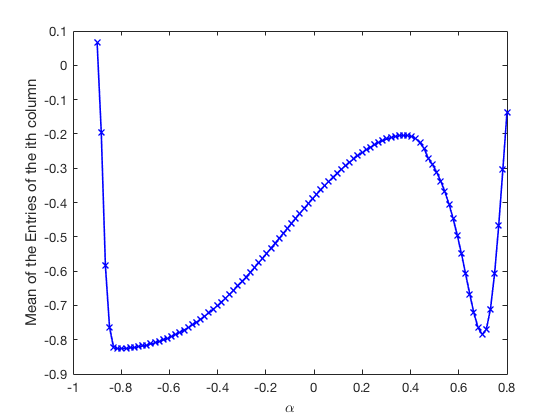

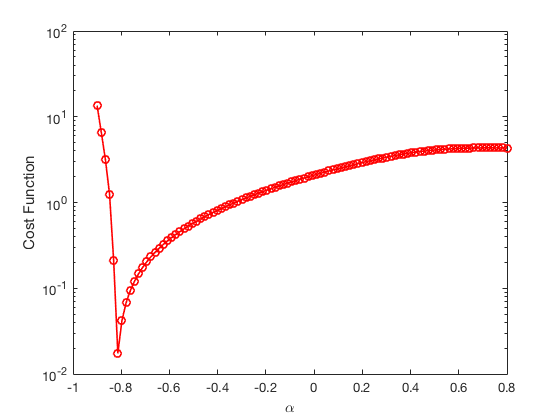

In [42]:
semilogy(alpha_test,val_opt,'-or','LineWidth',1.2)
xlabel('\alpha'), ylabel('Cost Function')
figure,
plot(alpha_test,mean_entry,'-xb','LineWidth',1.2)
xlabel('\alpha'), ylabel('Mean of the Entries of the ith column')

In [43]:
% Retriving best solution
alpha_true = alpha_test(val_opt == min(val_opt));
cvx_begin quiet

    variable H(n,n) skew_symmetric
    
    expression uOne
    
    uOne = (eye(n) + H)*Lm*Uat;
    
    minimize ( norm(C*(eye(n) + H) - (Ct/Lm)*(eye(n) - H),'fro') )
    
    subject to

        uOne(:,3) <= alpha_true*(eye(n) - H)*ones(n,1)
cvx_end

Uline = (eye(n) - H)\uOne;

In [44]:
% Removing scaling of the found eigenbasis
Ex = sqrtm(Uline'*Uline)^-1;
% Estimated Eigenbasis for L
Unew = Uline*Ex;

In [45]:
% Checking Diagonalization of L
disp('U_est^T * U = ')
disp(Unew'*U)
disp('U_est^T * L * U_est = ')
disp(Unew'*L*Unew)
disp('True Eigenvalues')
disp(eig(L)')
disp('Retrieved Eigenvalues')
disp(sort(diag(Unew'*L*Unew)','ascend'))

U_est^T * U = 
    0.0092    0.0068   -0.0008    0.0002    0.9999
   -0.0051   -0.0035    0.0013    1.0000   -0.0001
   -0.9999   -0.0042   -0.0089   -0.0051    0.0092
   -0.0088   -0.0064    0.9999   -0.0014    0.0010
   -0.0043    0.9999    0.0064    0.0035   -0.0067

U_est^T * L * U_est = 
    0.9999    0.0000    0.0092    0.0006   -0.0046
    0.0000    0.8196   -0.0042   -0.0007    0.0018
    0.0092   -0.0042    0.0001   -0.0032   -0.0014
    0.0006   -0.0007   -0.0032    0.3592    0.0003
   -0.0046    0.0018   -0.0014    0.0003    0.3131

True Eigenvalues
   -0.0000    0.3131    0.3592    0.8196    1.0000

Retrieved Eigenvalues
    0.0001    0.3131    0.3592    0.8196    0.9999

